# HW3: Image Captioning

In this assignment we will be using convnets and an RNN (LSTM in this case) to take in images and return naturual language descriptions for them. We highly encourage you to complete this on Google Colab with a GPU runtime.

We will be working with Microsoft's COCO dataset, a large image dataset with acompanying text cpations for the images.

When working in colab, if your computer disconnects or is left idle, you will likely lose all progress and any files you've downloaded, so be careful of this.

**Acknowledgement:** This assignment is made possible with the help of this awesome pytorch tutorial: https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning

In [1]:
# If you are using colab, you can upload the data to google drive and use the code to connect to your google drive in colab. It allows you to not have to upload the data every time you run it.
from google.colab import drive
drive.mount('/content/drive/')

# Then, use tar -zxvf command to unzip
!tar -zxvf /content/drive/MyDrive/pretrain_models.tar.gz
!tar -zxvf /content/drive/MyDrive/hw3test_images.gz
!tar -zxvf /content/drive/MyDrive/hw3data.tar.gz

Mounted at /content/drive/
tar (child): /content/drive/MyDrive/pretrain_models.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
tar (child): /content/drive/MyDrive/hw3test_images.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
tar (child): /content/drive/MyDrive/hw3data.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence


class EncoderCNN(nn.Module):
    #extract freatures using pretrained resnet
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer (classification layer)
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size) #project final feature map into embedding dimension for RNN
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01) #normalize embeddings

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size) #creates embeddings layer based on num words and embedding size
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True) #number of stacked lstm layers
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length

    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs



Here we create the vocabulary class. This builds a vocabulary of all the captions we see during learning and allows us to quickly access them with indexes.

In [ ]:
import nltk
import pickle
import argparse
from collections import Counter
from pycocotools.coco import COCO


class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def build_vocab(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

Below are helper functions for COCO.

In [ ]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import os
import pickle
import numpy as np
import nltk
from PIL import Image
from pycocotools.coco import COCO


class CocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, root, json, vocab, transform=None):
        """Set the path for images, captions and vocabulary wrapper.

        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        coco = self.coco
        vocab = self.vocab
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.ids)


def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).

    We should build custom collate_fn rather than using default collate_fn,
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption).
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

def get_loader(root, json, vocab, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco = CocoDataset(root=root,
                       json=json,
                       vocab=vocab,
                       transform=transform)

    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    data_loader = torch.utils.data.DataLoader(dataset=coco,
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader

Some helper functions for our images.

In [ ]:
import argparse
import os
from PIL import Image


def resize_image(image, size):
    """Resize an image to the given size."""
    return image.resize(size, Image.LANCZOS)

def resize_images(image_dir, output_dir, size):
    """Resize the images in 'image_dir' and save into 'output_dir'."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                img = resize_image(img, size)
                img.save(os.path.join(output_dir, image), img.format)
        if (i+1) % 100 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_images, output_dir))


We will create our vocabulary using nltk's punkt, a popular sentence tokenizer.

In [ ]:
nltk.download('punkt')
caption_path = "data/annotations/captions_train2014.json"
vocab_path = "data/vocab.pkl"
threshold = 4
vocab = build_vocab(caption_path, threshold)
with open(vocab_path, 'wb') as f:
  pickle.dump(vocab, f)

print(f"Total vocabulary size: {len(vocab)}")
print(f"Saved the vocabulary wrapper to {vocab_path}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
[1000/414113] Tokenized the captions.
[2000/414113] Tokenized the captions.
[3000/414113] Tokenized the captions.
[4000/414113] Tokenized the captions.
[5000/414113] Tokenized the captions.
[6000/414113] Tokenized the captions.
[7000/414113] Tokenized the captions.
[8000/414113] Tokenized the captions.
[9000/414113] Tokenized the captions.
[10000/414113] Tokenized the captions.
[11000/414113] Tokenized the captions.
[12000/414113] Tokenized the captions.
[13000/414113] Tokenized the captions.
[14000/414113] Tokenized the captions.
[15000/414113] Tokenized the captions.
[16000/414113] Tokenized the captions.
[17000/414113] Tokenized the captions.
[18000/414113] Tokenized the captions.
[19000/414113] Tokenized the captions.
[20000/414113] Tokenized the captions.
[21000/414113] Tokenized the captions.
[22000/414113] Tokenized the captions.
[23000/414113] Tokenized the captions.
[24000/414113] Tokenized the 

We will set some parameters below for our images, paths, and training.

Note that if you lose connection to Colab during execution, you will lose all progress/uploaded files. Because of this we will only be training for 1 epoch. If you would like to better train the network, we encourage you to train longer (try 5 epochs). Note this is optional.

In [ ]:
model_path = "models/"
crop_size = 100
vocab_path = "data/vocab.pkl"
image_dir = "data/resized2014"
caption_path = "data/annotations/captions_train2014.json"
test_image_dir = "test_images"
pretrained_model_dir = "pretrain_models"
log_step = 10
save_step = 3000
embed_size = 256
hidden_size = 512
num_layers = 1

num_epochs = 1 # We only train 1 epoch for reducing training time
batch_size = 128
num_workers=1
learning_rate = 0.001

In [ ]:
## Please DONOT remove these lines.
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

Let's now create our training loop. We will first must add transforms to our images and create a dataloader.

We then initialize our models, the encoder and decober and setup loss and optimizer.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if not os.path.exists(model_path):
    os.makedirs(model_path)


transform = transforms.Compose([
  # TODO 1: Image transformation. Add a random crop size crop_size and random horizontal flip (default parameters) to the below transform. see https://pytorch.org/vision/stable/transforms.html. 2 lines of code.
  ### START CODE
  transforms.RandomResizedCrop(size = crop_size, antialias=True),
  transforms.RandomHorizontalFlip(p=0.5),
  ### END CODE
  transforms.ToTensor(),
  transforms.Normalize((0.485, 0.456, 0.406),
                      (0.229, 0.224, 0.225))])

with open(vocab_path, 'rb') as f:
  vocab = pickle.load(f)

# TODO 2: Data loader creation. Create your data loader using the get_loader function. 1 line of code.
### START CODE
#def get_loader(root, json, vocab, transform, batch_size, shuffle, num_workers)
data_loader = get_loader(image_dir, caption_path, vocab, transform, batch_size, shuffle=True, num_workers=0)
### END CODE

encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

# TODO 3: Loss function creation. Create a cross entropy loss to optimize the captioning model. 1 line of code.
### START CODE
criterion = nn.CrossEntropyLoss()
### END CODE
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

total_step = len(data_loader)
for epoch in range(num_epochs):
  for i, (images, captions, lengths) in enumerate(data_loader):

    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)
    decoder.zero_grad()
    encoder.zero_grad()
    loss.backward()
    optimizer.step()

    if i % log_step == 0:
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
        .format(epoch, num_epochs, i, total_step, loss.item(), np.exp(loss.item())))

    # Save the model checkpoints
    if (i+1) % save_step == 0:
      torch.save(decoder.state_dict(), os.path.join(
          model_path, 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
      torch.save(encoder.state_dict(), os.path.join(
          model_path, 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))


loading annotations into memory...
Done (t=1.06s)
creating index...
index created!
Epoch [0/1], Step [0/3236], Loss: 9.2131, Perplexity: 10027.4092
Epoch [0/1], Step [10/3236], Loss: 5.7718, Perplexity: 321.1266
Epoch [0/1], Step [20/3236], Loss: 5.3047, Perplexity: 201.2762
Epoch [0/1], Step [30/3236], Loss: 5.0691, Perplexity: 159.0246
Epoch [0/1], Step [40/3236], Loss: 4.6682, Perplexity: 106.5083
Epoch [0/1], Step [50/3236], Loss: 4.5015, Perplexity: 90.1559
Epoch [0/1], Step [60/3236], Loss: 4.3710, Perplexity: 79.1264
Epoch [0/1], Step [70/3236], Loss: 4.0969, Perplexity: 60.1540
Epoch [0/1], Step [80/3236], Loss: 4.1826, Perplexity: 65.5391
Epoch [0/1], Step [90/3236], Loss: 3.9716, Perplexity: 53.0672
Epoch [0/1], Step [100/3236], Loss: 4.1256, Perplexity: 61.9034
Epoch [0/1], Step [110/3236], Loss: 3.6954, Perplexity: 40.2615
Epoch [0/1], Step [120/3236], Loss: 3.6976, Perplexity: 40.3490
Epoch [0/1], Step [130/3236], Loss: 3.6718, Perplexity: 39.3240
Epoch [0/1], Step [140/32

After training one epoch, the loss value should be 2.2-2.7 and perplexity should be 9-12.

In [ ]:
def load_image(image_path, size=100, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([size, size], Image.LANCZOS)

    if transform is not None:
        image = transform(image).unsqueeze(0)

    return image

In [ ]:
import string

def generate_caption(encoder, decoder, device, image):
    # Image feature extraction. Use encoder to extract image features. 1-2 lines of code.
    # The input image is sent to the specified device (CPU/GPU).
    # The encoder processes the image to extract high-level features, which act as input for the decoder.
    image = image.to(device)
    features = encoder(image)

    # Initialize variables for decoding.
    # sampled_ids will store the predicted word indices for the caption.
    # inputs are initialized as the reshaped features tensor to match the decoder's LSTM input format.
    # states represent the hidden and cell states of the LSTM, initially set to None.
    sampled_ids = []
    inputs = features.unsqueeze(1)
    states = None

    # Sentence sequential decoding with greedy search at each time step of testing.
    # Loop for a fixed number of decoding steps defined by decoder.max_seg_length.
    for i in range(decoder.max_seg_length):
        # Pass inputs and states through the LSTM in the decoder.
        # hiddens: LSTM output for the current time step.
        # states: Updated hidden and cell states of the LSTM.
        hiddens, states = decoder.lstm(inputs, states)  # hiddens: (batch_size, 1, hidden_size)

        # Map LSTM output (hiddens) to vocabulary-sized logits using a linear layer.
        # outputs: Probability scores for each word in the vocabulary.
        outputs = decoder.linear(hiddens.squeeze(1))  # outputs: (batch_size, vocab_size)

        # Perform greedy search by selecting the index of the word with the highest probability.
        # predicted: Index of the predicted word.
        _, predicted = outputs.max(1)  # predicted: (batch_size)

        # Append the predicted word index to the list of sampled_ids.
        sampled_ids.append(predicted)

        # Convert the predicted word index to its embedding using the decoder's embed layer.
        # The embedding is used as the input for the next time step.
        inputs = decoder.embed(predicted)  # inputs: (batch_size, embed_size)

        # Reshape inputs to match the expected LSTM input format.
        inputs = inputs.unsqueeze(1)  # inputs: (batch_size, 1, embed_size)

    # Combine all predicted indices into a tensor.
    # sampled_ids will have shape (batch_size, max_seq_length).
    sampled_ids = torch.stack(sampled_ids, 1)

    # Assuming batch size of 1, extract the sequence of word indices as a NumPy array.
    sampled_ids = sampled_ids[0].cpu().numpy()

    # Convert word indices to words.
    # sampled_caption will store the final list of words in the generated caption.
    sampled_caption = []
    for word_id in sampled_ids:
        # Convert the word index to the corresponding word using vocab.idx2word.
        word = vocab.idx2word[word_id]

        # Stop processing if the <end> token is encountered.
        if word == '<end>':
            break

        # Skip the <start> token and punctuation.
        if word == "<start>" or word in string.punctuation:
            continue

        # Add the word to the sampled_caption list.
        sampled_caption.append(word)

    # Combine the list of words into a complete sentence, separated by spaces.
    sentence = " ".join(sampled_caption)

    # Return the generated sentence as the caption for the image.
    return sentence


stern woods childs billboard chain rich woods snuggles kids woods years numeral


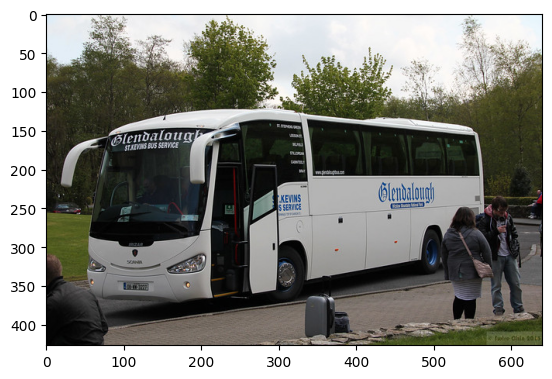

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

image1_path = os.path.join(test_image_dir, "image1.jpg")
transform = transforms.Compose([ transforms.ToTensor(),  transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])
image1 = load_image(image1_path, 100, transform)

encoder.eval()
decoder.eval()
caption1 = generate_caption(encoder, decoder, device, image1)

# Print out the image and the generated caption
print(caption1)
image1 = Image.open(image1_path)
plt.imshow(np.asarray(image1))

Try and send `image2` and `image3` through the network and see what the resulting captions are.

rich woods renovated china scott receipt domed woods slivers numeral


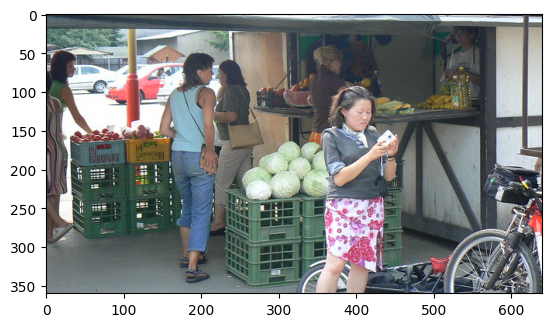

In [ ]:
image2_path = os.path.join(test_image_dir, "image2.jpg")
image2 = load_image(image2_path, 100, transform)
caption2 = generate_caption(encoder, decoder, device, image2)
# Print out the image and the generated caption
print(caption2)
image = Image.open(image2_path)
plt.imshow(np.asarray(image))

woods childs billboard chain domed woods slivers rich cookers technology numeral


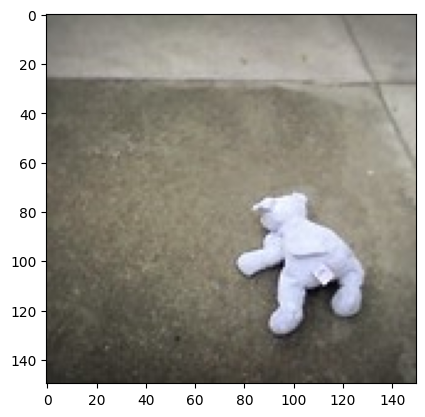

In [ ]:
image3_path = os.path.join(test_image_dir, "image3.jpg")
image3 = load_image(image3_path, 100, transform)
caption3 = generate_caption(encoder, decoder, device, image3)
print(caption3)
image = Image.open(image3_path)
plt.imshow(np.asarray(image))

If you chose not to fully train the network and left the epochs to its default, the network may not be giving very satisfying captions.

Let's load in a pretrained network and see its results.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


a bus that is parked in a parking lot


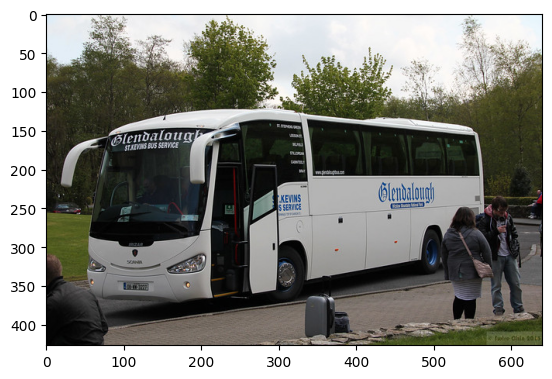

In [ ]:
vocab = pickle.load(open(os.path.join(pretrained_model_dir, "vocab.pkl"), "rb"))

# Load given well-trained captioning model weights and test. Create an encoder with embed size 256, set to eval mode, and load provided pre-trained weights of encoder. 3-5 lines of code.

encoder_pretrained = EncoderCNN(embed_size = 256).to(device)
encoder_pretrained.eval()
encoder_pretrained.load_state_dict(torch.load(os.path.join(pretrained_model_dir, 'encoder-5-3000.pkl')))

decoder_pretrained = DecoderRNN(embed_size=256, hidden_size=512, vocab_size=len(vocab), num_layers=1).to(device)
encoder = encoder_pretrained.to(device)
decoder_pretrained = decoder_pretrained.to(device)
decoder_pretrained.load_state_dict(torch.load(os.path.join(pretrained_model_dir, 'decoder-5-3000.pkl')))

transform = transforms.Compose([ transforms.ToTensor(),  transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

# Prepare an image
image1_path = os.path.join(test_image_dir, "image1.jpg")
image = Image.open(image1_path).convert('RGB')
image = image.resize([224, 224], Image.LANCZOS)
image = transform(image).unsqueeze(0)
sentence = generate_caption(encoder_pretrained, decoder_pretrained, device, image)
# Print out the image and the generated caption
print (sentence)
image = Image.open(image1_path)
plt.imshow(np.asarray(image))

Send the remaining images, image2 and image3 to the network and get the predicted captions.

a group of people standing around a table with a bunch of bananas


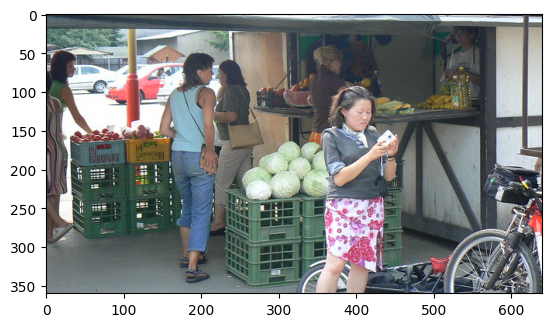

In [ ]:
image2_path = os.path.join(test_image_dir, "image2.jpg")
image2 = Image.open(image2_path).convert('RGB')
image2 = image2.resize([224, 224], Image.LANCZOS)
image2 = transform(image2).unsqueeze(0)
sentence2 = generate_caption(encoder_pretrained, decoder_pretrained, device, image2)

# Print out the image and the generated caption
print(sentence2)
image2 = Image.open(image2_path)
plt.imshow(np.asarray(image2))

a cat sitting on a chair next to a cat


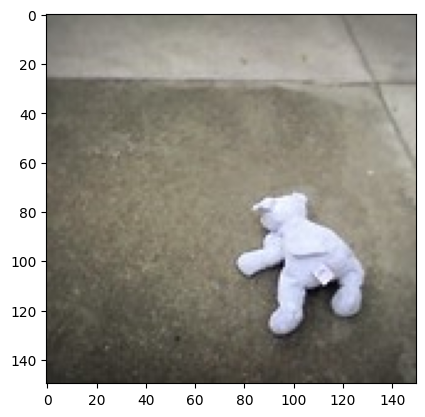

In [ ]:
image3_path = os.path.join(test_image_dir, "image3.jpg")
image3 = Image.open(image3_path).convert('RGB')
image3 = image3.resize([224, 224], Image.LANCZOS)
image3 = transform(image3).unsqueeze(0)
sentence3 = generate_caption(encoder_pretrained, decoder_pretrained, device, image3)

# Print out the image and the generated caption
print(sentence3)
image3 = Image.open(image3_path)
plt.imshow(np.asarray(image3))